# A numerical study of fixation probabilities for strategies in the Prisoners  Dilemma

This notebook contains all the Python code used to generate the plots and figures for the paper.

Here are the versions of the various libraries used:

In [1]:
%matplotlib inline

import axelrod as axl
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sympy as sym
import itertools


from mpl_toolkits.axes_grid1 import make_axes_locatable
from pandas.util.testing import assert_frame_equal

import math
import imp
players = imp.load_source('players', '../src/players.py')
generate_cache = imp.load_source('players', '../src/generate_cache.py')
theoretic = imp.load_source('theoretic', '../src/theoretic.py')
abbreviations = imp.load_source('abbreviations', '../src/abbreviations.py')

assert axl.__version__ == '2.9.0' 
assert pd.__version__ == '0.19.2'
assert matplotlib.__version__ == '2.0.0'
assert sns.__version__ == '0.7.1'
assert np.__version__ == '1.12.1'
assert sym.__version__ == '1.0'

## Description of the used strategies

Here are all the strategies used in this experiment:

In [2]:
from abbreviations import abbreviations

def abbreviate(player_name, abbreviations=abbreviations):
    """
    Return the abbreviated name of a play if one has been given
    """
    if isinstance(player_name, axl.Player):
        player_name = str(player_name)
    return abbreviations.get(player_name, player_name)

assert abbreviate("Tit For Tat") == "TfT"
assert abbreviate("Random: 0.5") == "Random"
assert abbreviate(axl.TitForTat()) == "TfT"

In [3]:
from players import selected_players
players_of_interest = set([p for p in selected_players() 
                           if ("length" not in p.classifier["makes_use_of"]) and
                              ("Incorrect" not in abbreviate(p))])
                      
assert len(players_of_interest) == 164

These players have been omitted from the analysis (even though their data was collected). This is because they use the match length or were entered in to the original data sweep by error (the FSM strategies do not use the correct initial state).

In [4]:
set(map(str, selected_players())) - set(map(str, players_of_interest))

{"BackStabber: ('D', 'D')",
 'Champion',
 "DoubleCrosser: ('D', 'D')",
 "FSM Player: [(0, 'C', 0, 'C'), (0, 'D', 3, 'C'), (1, 'C', 5, 'D'), (1, 'D', 0, 'C'), (2, 'C', 3, 'C'), (2, 'D', 2, 'D'), (3, 'C', 4, 'D'), (3, 'D', 6, 'D'), (4, 'C', 3, 'C'), (4, 'D', 1, 'D'), (5, 'C', 6, 'C'), (5, 'D', 3, 'D'), (6, 'C', 6, 'D'), (6, 'D', 6, 'D'), (7, 'C', 7, 'D'), (7, 'D', 5, 'C')], 1, C",
 "FSM Player: [(0, 'C', 13, 'D'), (0, 'D', 12, 'D'), (1, 'C', 3, 'D'), (1, 'D', 4, 'D'), (2, 'C', 14, 'D'), (2, 'D', 9, 'D'), (3, 'C', 0, 'C'), (3, 'D', 1, 'D'), (4, 'C', 1, 'D'), (4, 'D', 2, 'D'), (5, 'C', 12, 'C'), (5, 'D', 6, 'C'), (6, 'C', 1, 'C'), (6, 'D', 14, 'D'), (7, 'C', 12, 'D'), (7, 'D', 2, 'D'), (8, 'C', 7, 'D'), (8, 'D', 9, 'D'), (9, 'C', 8, 'D'), (9, 'D', 0, 'D'), (10, 'C', 2, 'C'), (10, 'D', 15, 'C'), (11, 'C', 7, 'D'), (11, 'D', 13, 'D'), (12, 'C', 3, 'C'), (12, 'D', 8, 'D'), (13, 'C', 7, 'C'), (13, 'D', 10, 'D'), (14, 'C', 10, 'D'), (14, 'D', 7, 'D'), (15, 'C', 15, 'C'), (15, 'D', 11, 'D')], 1,

In [5]:
with open("../tex/list_of_players.tex", "w") as f:
    for player in sorted(players_of_interest, key=str):
        latex_name = "{}\n".format(player).replace("_", "\_")
        f.write("\item {}".format(latex_name))
        abbreviation = abbreviate(player)
        if abbreviation != player.name:
            f.write("(\\textbf{{{}}})".format(abbreviation))

Here are some summary information about the strategies

In [6]:
def clean_mem(n):
    try:
        return int(n)
    except OverflowError:
        return -1

player_info = pd.DataFrame([[abbreviate(p), p.classifier["stochastic"], clean_mem(p.classifier['memory_depth'])] 
                        for p in players_of_interest], 
                       columns=["Player", "Stochastic", "Memory Depth"])

In [7]:
temp_df = pd.DataFrame(player_info.groupby("Stochastic")["Player"].count()).reset_index().rename(columns={"Player": "Count"})
for bool in [True, False]:
    filename = "../tex/num_stochastic.tex" if bool else "../tex/num_deterministic.tex"
    with open(filename, "w") as f:
        num = temp_df[temp_df["Stochastic"] == bool]["Count"].iloc[0]
        print(num, bool)
        f.write(str(num))

43 True
121 False


In [8]:
temp_df = pd.DataFrame(player_info.groupby("Memory Depth")["Player"].count()).transpose()
temp_df.rename(index={"Player": "Count"}, inplace=True)
cols = temp_df.columns.tolist()
temp_df = temp_df[cols[1:] + [cols[0]]]
temp_df

Memory Depth,0,1,2,3,4,5,6,9,10,11,12,16,20,40,200,-1
Count,3,31,12,8,2,6,1,1,5,1,1,2,2,2,1,86


In [9]:
def clean_latex(string):
    """Replace some special carachters"""
    string = string.replace("textbackslashpi", "pi")
    string = string.replace("textbackslashphi", "phi")
    string = string.replace("\\$", "$")
    string = string.replace("\\$", "$")
    string = string.replace("\\textasciicircum", "^")
    string = string.replace("\_", "_")
    string = string.replace("2_2_2", "2\_2\_2")
    return string

with open("../tex/memory_depth_count.tex", "w") as f:
    string = clean_latex(temp_df.to_latex()).replace("-1", "\(\infty\)")
    f.write(string)

## Illustrating the Approximate moran process

In [12]:
cached_outcomes = pd.read_csv("../data/outcomes.csv", header=None, 
                              names=["Player 1", "Player 2", "Score 1", "Score 2", "Iteration"])

cached_outcomes["Player 1"] = cached_outcomes["Player 1"].apply(lambda x: abbreviate(x))
cached_outcomes["Player 2"] = cached_outcomes["Player 2"].apply(lambda x: abbreviate(x))

cached_outcomes = cached_outcomes[cached_outcomes["Player 1"].isin(player_info["Player"]) & 
                                  cached_outcomes["Player 2"].isin(player_info["Player"])]

assert len(cached_outcomes.index) == 1169001

In [14]:
cached_outcomes.head()

,Player 1,Player 2,Score 1,Score 2,Iteration
0,Alternator Hunter,Prober 2,2.985,3.010,1
1,Alternator Hunter,Prober 3,0.015,4.990,1
2,Adaptive,Adaptive,2.950,2.950,1
3,Alternator Hunter,Prober 4,0.150,4.900,1
4,Adaptive,Adaptive Tit For Tat,2.955,2.955,1


In [15]:
is_stochastic = dict(zip(player_info["Player"], player_info["Stochastic"]))

In [16]:
temp_df = pd.DataFrame(cached_outcomes.groupby(["Player 1", "Player 2"]).count()).reset_index()
temp_df["Outcome count"] = temp_df["Score 1"]
temp_df.drop(["Score 1", "Score 2", "Iteration"], axis=1, inplace=True)

In [17]:
temp_df["Stochastic"] = ((temp_df["Player 1"].map(lambda p: is_stochastic[p]) | 
                          temp_df["Player 2"].map(lambda p: is_stochastic[p])) & 
                         (temp_df["Outcome count"] > 1))

In [18]:
temp_df.head()

,Player 1,Player 2,Outcome count,Stochastic
0,$\phi$,$\phi$,1,False
1,$\phi$,$\pi$,1,False
2,$\phi$,$e$,1,False
3,$\phi$,2TfT,1,False
4,$\phi$,Gradual,1,False


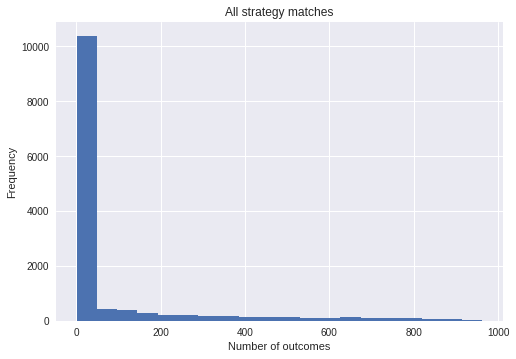

In [19]:
plt.figure()
plt.hist(temp_df["Outcome count"], bins=20)
plt.xlabel("Number of outcomes")
plt.ylabel("Frequency")
plt.title("All strategy matches");
plt.savefig("../img/number_of_match_outcomes.pdf")

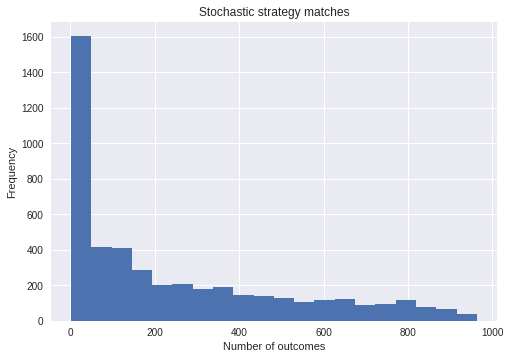

In [20]:
plt.figure()
plt.hist(temp_df[temp_df["Stochastic"]]["Outcome count"], bins=20)
plt.xlabel("Number of outcomes")
plt.ylabel("Frequency")
plt.title("Stochastic strategy matches")
plt.savefig("../img/number_of_stochastic_match_outcomes.pdf");

## Validating the model

Here we create a number of plots comparing the theoretic fixation probability with the observed fixation probability for a number of initial starting populations.

In [21]:
validation = pd.read_csv("../data/fixation_validation.csv", index_col=False)

In [22]:
validation.tail()

,Repetitions,N,i,Player 1,Player 2,Theoretic,Simulated
555,1000,20,19,Alternator,PSO Gambler 2_2_2,0.652689,0.634
556,1000,20,10,Random: 0.5,GTFT: 0.33,0.588176,0.586
557,1000,20,10,Cooperator,"ZD-Extort-2: 0.1111111111111111, 0.5",0.804411,0.855
558,1000,20,19,Cooperator,"ZD-Extort-2: 0.1111111111111111, 0.5",0.968989,0.981
559,1000,20,19,Random: 0.5,GTFT: 0.33,0.974838,0.977


/home/vince/anaconda3/envs/moran/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


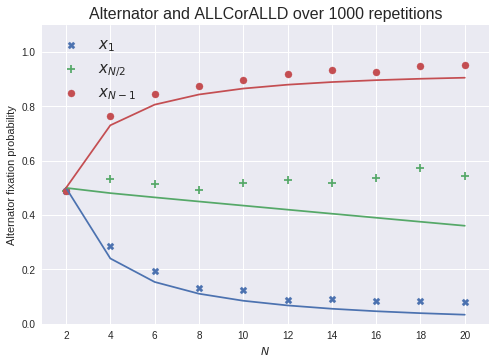

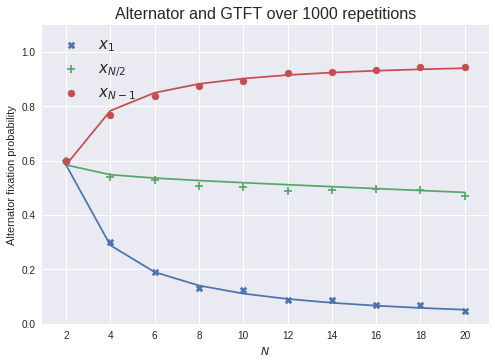

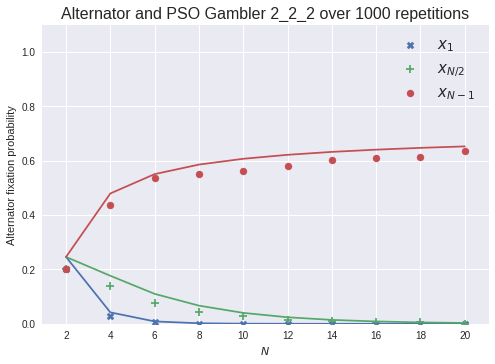

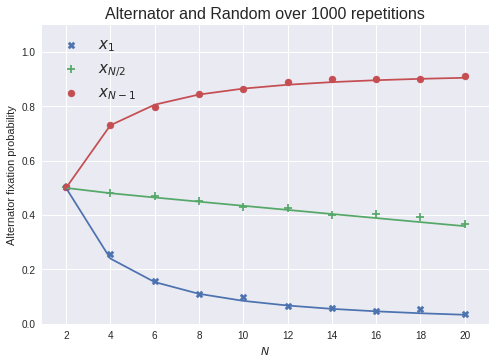

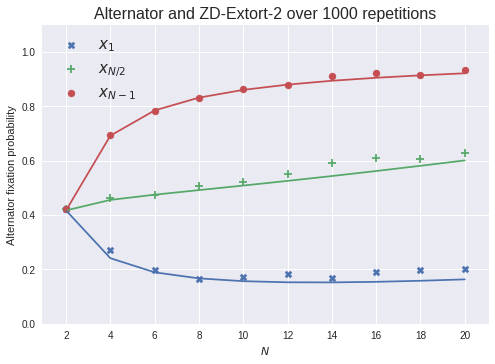

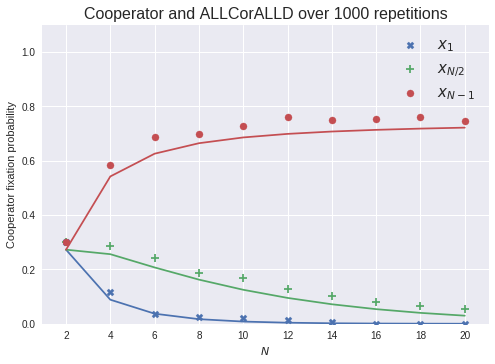

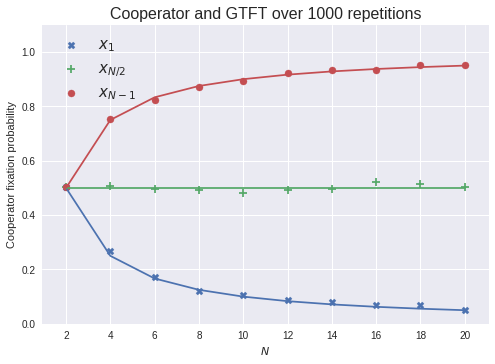

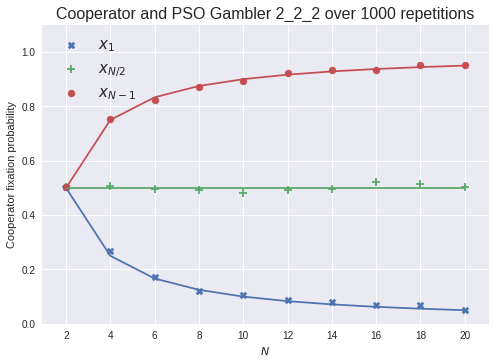

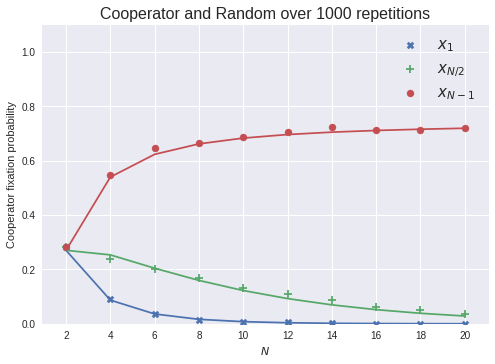

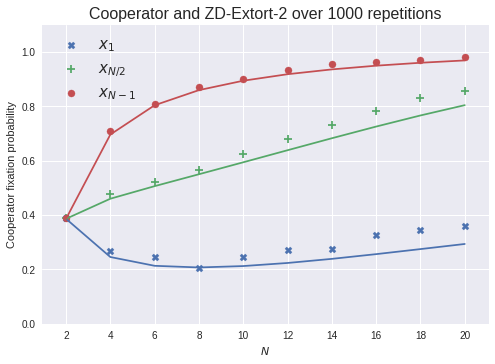

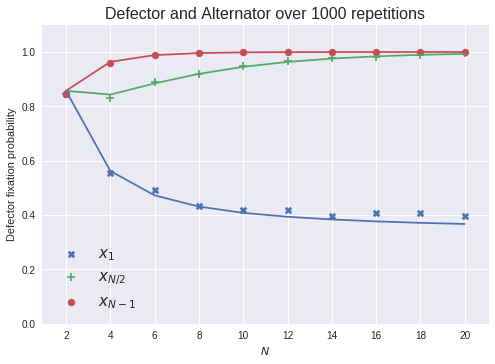

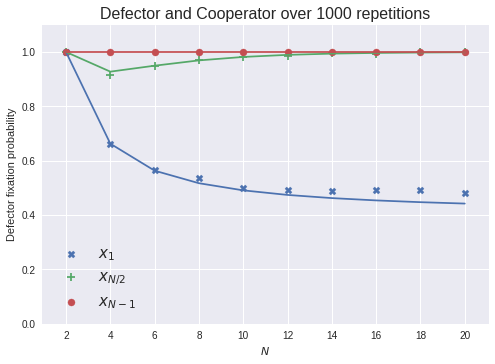

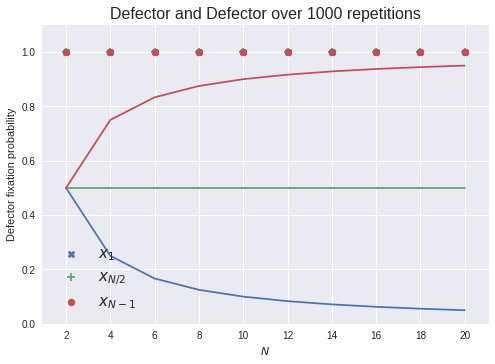

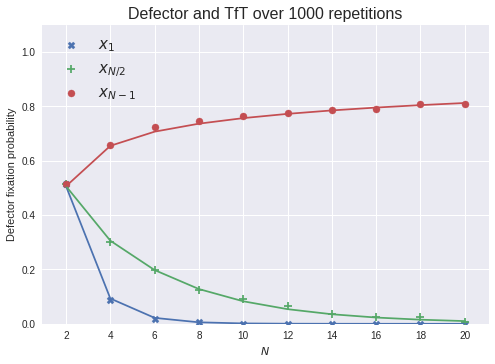

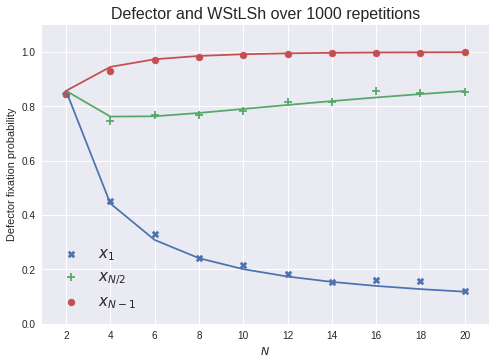

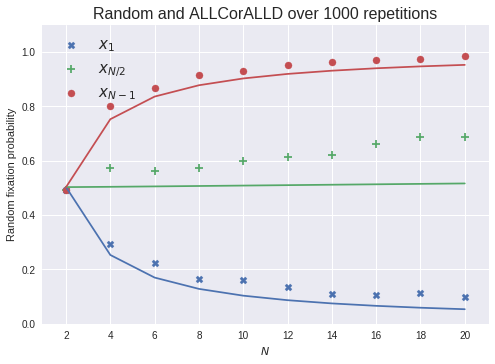

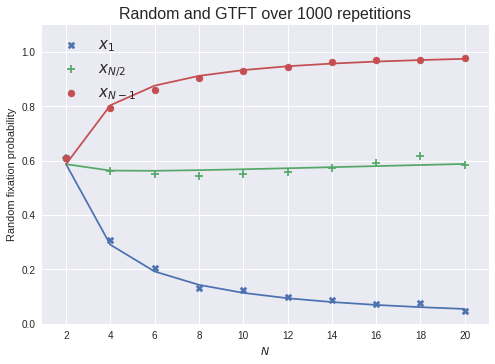

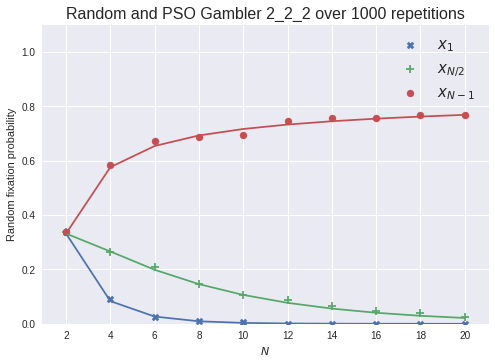

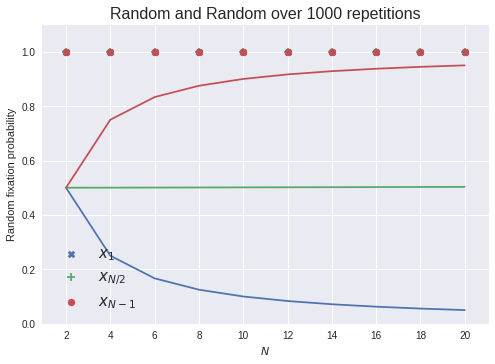

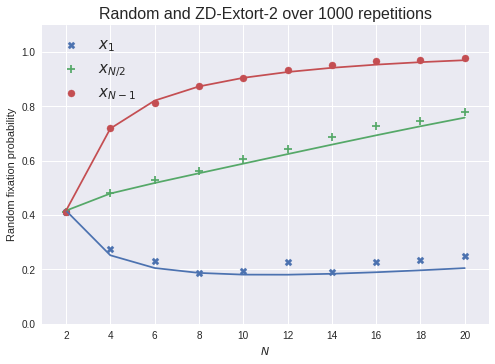

In [23]:
markers = itertools.cycle(('X', '+', 'o')) 
marker_size = 50
fontsize=16

for names, df in validation.groupby(["Player 1", "Player 2"]):
    df.sort_values("N", inplace=True)
    
    repetitions = df["Repetitions"].iloc[0]
    assert all(df["Repetitions"] == repetitions)
    
    # Get names instead of repr (to drop some parameters)
    names = [abbreviate(name) for name in names]
    title = "{} and {} over {} repetitions".format(*names, repetitions)
    filename = "{}_v_{}".format(*names)

    for substr in [": ", ".", ":", " "]:
        filename = filename.replace(substr, "_")
    
    plt.figure()

    labels = ["1", "N / 2", "N - 1"]
    index_sets = [df["i"] == 1, df["i"]  == df["N"] / 2, df["i"] == df["N"] - 1]
    for label, index in zip(labels, index_sets):
        d = df[index]
        plt.plot(d["N"], d["Theoretic"], label="")
        plt.scatter(d["N"], d["Simulated"], marker=next(markers), 
                        label="$x_{{{}}}$".format(label), s=marker_size)
    plt.xticks(d["N"])
    plt.title(title, fontsize=fontsize)
    plt.ylim(0, 1.1)
    plt.ylabel("{} fixation probability".format(names[0]))
    plt.xlabel("$N$")
    plt.legend(fontsize=15)
    plt.savefig("../img/{}.pdf".format(filename))

# Carry out analysis of Moran processes

In [ ]:
main = pd.read_csv("../data/main.csv")
main["player"] = main["player"].apply(lambda x: abbreviate(x))
main["opponent"] = main["opponent"].apply(lambda x: abbreviate(x))
main = main[main["player"].isin(player_info["Player"]) &
            main["opponent"].isin(player_info["Player"])]

# Test known values
expected = pd.DataFrame([["Cooperator", "Defector", 10, 0, 0.019, float("nan"), 0.454, 0.500, 0.500],
                         ["TfT", "Defector", 10, 0.262, 0.915, 1.327, 1.608, 0.999, 1.994]],
                        columns=main.columns)
assert_frame_equal(expected, main[((main["player"] == "TfT") | (main["player"] == "Cooperator")) & 
                                  (main["opponent"] == "Defector") & 
                                  (main["N"] == 10)].round(3).reset_index(drop=True))

In [ ]:
# Check number of completed  matches: 164 strategies implies 13366 pairs. 
# Each pair is considered twice (invader/resistor)
for N, df in main.groupby("N"):
    if N <= 12: # TODO remove this if statement once all data has been collected
        num_p_1 = len(df["$p_1$"].dropna().index)
        num_p_n_over_2 = len(df["$p_{N/2}$"].dropna().index)
        num_p_n_minus_1 = len(df["$p_{N-1}$"].dropna().index)
        if N % 2 == 1:
            assert (num_p_1 == num_p_n_minus_1 == 13366 * 2)
            assert num_p_n_over_2 == 0
        else:
            assert num_p_1 == num_p_n_over_2  == num_p_n_minus_1 == 13366 * 2

In [ ]:
main.head()

In [ ]:
main[(main["player"] == "TfT") & (main["opponent"] == "Defector")]

This shows:

- $p_1$: fixation probability of 1 `player` in population of `N-1` `opponent`s
- $p_{N/2}$: fixation probability of `N/2` `player`s in population of `N/2` `opponent`s
- $p_{N - 1}$: fixation probability of `N - 1` `player`s in population of `1` `opponent`s
- $r_1$: relative fitness of 1 `player` in population of `N-1` `opponent`s
- $r_{N/2}$: relative fitness of `N/2` `player`s in population of `N/2` `opponent`s
- $r_{N - 1}$: retlative of `N - 1` `player`s in population of `1` `opponent`s

### Mean fixation probability for each strategy

In [ ]:
plot_file_labels = ["invade", "resist", "coexist"]

In [ ]:
main.head()

In [ ]:
plt.rcParams['figure.figsize'] = 25, 35
fontsize = 20


for N in range(2, 14 + 1):
    
    temp_df = main[main["N"] == N].dropna(axis=1)
    if N == 2:
        values = ['$p_1$']
    else:
        values = ['$p_1$', '$p_{N-1}$']
    for value, plot_file_label in zip(values, plot_file_labels):

            fig, ax = plt.subplots()
            data, labels = [], []
        
            try:
                for player, df in temp_df.groupby("player"):

                    data.append(list(df[value].dropna()))
                    labels.append(player)

                mean_fixation = [np.mean(ele) for ele in data]
                labels, data, _ = zip(*sorted(list(zip(labels, data, mean_fixation)), 
                                              key=lambda x: x[2]))
                # Plot the mean scores
                ax.boxplot(data, vert=False)

                xs = sorted(mean_fixation)
                ys = range(1, len(xs) + 1)
                ax.plot(xs, ys, linewidth=3)

                # Plot the neutral fixation
                if value == '$p_1$':
                    ax.axvline(1 / N, linestyle="dashed", linewidth=3, label="$\\frac{1}{N}$")
                elif value == '$p_{N/2}$':
                    ax.axvline(1 / 2, linestyle="dashed", linewidth=3, label="$\\frac{1}{2}$")
                else:
                    ax.axvline((N - 1) / N, linestyle="dashed", linewidth=3, label="$\\frac{N - 1}{N}$")

                ax.set_yticklabels(labels)
                ax.set_title("$N={}$ {}".format(N, value))
                ax.set_xlim((0, 1))
                ax.legend(fontsize=fontsize)

                fig.tight_layout()
                fig.savefig("../img/boxplot_{}_{}.pdf".format(N, plot_file_label))
            except KeyError: # Incomplete data
                pass

In [ ]:
def average_rank_df(col):
    
    df = pd.DataFrame(main.groupby(["player", "N"])[col].mean()).reset_index()
    return df.pivot(index="player", columns="N", values=col).rank(ascending=False).reset_index()

In [ ]:
mem_length = dict(zip(player_info["Player"], player_info["Memory Depth"]))

In [ ]:
def rank_summary_df(value, N=2, number=5):
    data = []
    temp_df = main[main["player"].isin(average_rank_df(value).sort_values(N).head(number)["player"]) & 
                   (main["N"] == N)]
    for player, df in temp_df.groupby("player"):
        data.append([player, np.mean(df[value].dropna()), mem_length[player], is_stochastic[player]])
    df = pd.DataFrame(data, columns=["Player", "Mean {}".format(value), "Memory Depth", "Stochastic"])
    return df.sort_values("Mean {}".format(value), ascending=False)

In [ ]:
for N in range(2, 14 + 1):
    
    temp_df = main[main["N"] == N].dropna(axis=1)
    if N == 2:
        values = ['$p_1$']
    #elif N % 2 == 0:
    #    values = ['$p_1$', '$p_{N-1}$', '$p_{N/2}$']
    else:
        values = ['$p_1$', '$p_{N-1}$']
    for value, plot_file_label in zip(values, plot_file_labels):
    
        temp_df = main[main["N"] == N].dropna(axis=1)
        if N == 2:
            values = ['$p_1$']
        elif N % 2 == 0:
            values = ['$p_1$','$p_{N-1}$', '$p_{N/2}$']
        else:
            values = ['$p_1$', '$p_{N-1}$']
        for value, plot_file_label in zip(values, plot_file_labels):

            temp_df = rank_summary_df(value=value, N=N)
            with open("../tex/summary_top_{}_{}.tex".format(N, plot_file_label), "w") as f:
                f.write(clean_latex(temp_df.to_latex(index=False).replace("-1", "\(\infty\)").replace("\{N\(\infty\)\}", "{N-1}")))

In [ ]:
def plot_ranks(rank_df):
    Ns = list(rank_df.columns[1:])
    
    fig, ax1 = plt.subplots()    
    
    sorted_df = rank_df.sort_values(Ns[0], ascending=False)
    ranks, labels = list(zip(*enumerate(sorted_df["player"])))
    ranks = [r + 1 for r in ranks]
    sorted_df = rank_df.sort_values(Ns[-1], ascending=False)
    last_labels = list(sorted_df["player"])
        
    for ax, labels in zip([ax1, ax1.twinx()], [labels, last_labels]):
        ax.set_ylim([min(ranks) - 3, max(ranks) + 3])
        ax.set_yticks(ranks)
        ax.set_yticklabels(labels)    
    
    sorted_df = rank_df.sort_values(Ns[0], ascending=False)
    color_indices = np.linspace(0, 1, len(labels))
    
    for color_index, (_, row) in enumerate(sorted_df.iterrows()):
        plot_color = matplotlib.cm.viridis(color_indices[color_index])
        ax1.plot([len(ranks) + 1 - r for r in list(row)[1:]], c=plot_color)

    ax1.set_xticks(range(len(Ns)))
    ax1.set_xticklabels(list(Ns))
    ax1.set_xlim(0, len(Ns) - 1)
    ax1.set_title("Ranks of Players for {}".format(value))
    fig.tight_layout()
    return fig

In [ ]:
df = average_rank_df("$p_1$").dropna(axis=1)

In [ ]:
plt.rcParams['figure.figsize'] = 25, 30

for value, plot_file_label in zip(['$p_1$','$p_{N-1}$', '$p_{N/2}$'], plot_file_labels):
    p = plot_ranks(average_rank_df(value).dropna(axis=1))
    p.savefig("../img/average_rank_vs_population_size_{}.pdf".format(plot_file_label))

In [ ]:
def get_correlation_coefficients(rank_df):
    temp_df = rank_df.dropna(axis=1).select_dtypes(include=['float64'])
    numeric_data = np.array(temp_df).transpose()
    return pd.DataFrame(np.corrcoef(numeric_data), 
                        columns=temp_df.columns, 
                        index=list(temp_df.columns)).round(2)

In [ ]:
plt.rcParams['figure.figsize'] = 25, 25

for value, plot_file_label in zip(['$p_1$','$p_{N-1}$', '$p_{N/2}$'], plot_file_labels):
    
    temp_df = get_correlation_coefficients(average_rank_df(value))

    with open("../tex/correlation_coeficients_{}.tex".format(plot_file_label), "w") as f:
        f.write(clean_latex(temp_df.to_latex()))
    print(temp_df)
    
    plt.figure()

    ax = plt.gca()
    im = plt.imshow(temp_df, cmap="viridis")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=1, pad=0.4)
    plt.colorbar(im, cax=cax)

    ax.set_yticks(range(len(temp_df.index)))
    ax.set_yticklabels(temp_df.index)

    ax.set_xticks(range(len(temp_df.index)))
    ax.set_xticklabels(temp_df.index)

    ax.set_title("{}".format(value))
    ax.grid(b=False)
    ax.patch.set_facecolor('None')

    plt.tight_layout()
    plt.savefig("../img/correlation_heatmap_{}.pdf".format(plot_file_label))

## Investigate relative fitness

A plot of the function $x_i=x_i(r)$:

In [ ]:
plt.rcParams['figure.figsize'] = 25, 10
fontsize=20

fig, ax = plt.subplots()
N = 10
rs = np.linspace(0, 4, 200)

for i in [1, N // 2, N - 1]:
    ps = [theoretic.phi(N, i, r) for r in rs]
    ax.plot(rs, ps, label="$p_{{{}, {}}}$".format(N, i))
    ax.set_xlabel("$r$", fontsize=fontsize)
    ax.legend(fontsize=fontsize);
    
fig.savefig("../img/fixation_v_fitness_illustration.pdf")

In [ ]:
N, i, r = sym.symbols('N, i, r')
xi_prime, xi_prime2 = sym.diff(theoretic.phi(N, i, r), r).simplify(), sym.diff(theoretic.phi(N, i, r), r, 2).simplify()


with open("../tex/fixation_probability_with_constant_relative_fitness_prime.tex", "w") as f:
    f.write(sym.latex(xi_prime))
    
with open("../tex/fixation_probability_with_constant_relative_fitness_prime2.tex", "w") as f:
    f.write(sym.latex(xi_prime2))

xi_prime, xi_prime2

In [ ]:
validation.head()

In [ ]:
def find_relative_fitness_with_error(N, i, p):
    try:
        return theoretic.find_relative_fitness(N, i, p)
    except RuntimeError:
        return float('nan')

validation["Fitness"] = validation.apply(lambda row: find_relative_fitness_with_error(row['N'], 
                                                                                      row['i'], 
                                                                                      row['Simulated']), 
                                         axis=1)

In [ ]:
validation.head()

In [ ]:
plt.rcParams['figure.figsize'] = 8, 6
markers = itertools.cycle(('X', '+', 'o')) 
marker_size = 50
fontsize=16

for names, df in validation.groupby(["Player 1", "Player 2"]):
    df.sort_values("N", inplace=True)
    
    repetitions = df["Repetitions"].iloc[0]
    assert all(df["Repetitions"] == repetitions)
    
    # Get names instead of repr (to drop some parameters)
    names = [abbreviate(name) for name in names]
    title = "{} and {} over {} repetitions".format(*names, repetitions)
    filename = "{}_v_{}_fitness".format(*names)

    for substr in [": ", ".", ":", " "]:
        filename = filename.replace(substr, "_")
    
    plt.figure()

    labels = ["1", "N / 2", "N - 1"]
    index_sets = [df["i"] == 1, df["i"]  == df["N"] / 2, df["i"] == df["N"] - 1]
    for label, index in zip(labels, index_sets):
        d = df[index]
        plt.scatter(d["N"], d["Fitness"], marker=next(markers), 
                        label="$r_{{{}}}$".format(label), s=marker_size)
    plt.xticks(d["N"])
    plt.title(title, fontsize=fontsize)
    plt.axhline(1, color="black")
    plt.ylabel("{} relative fitness".format(names[0]))
    plt.xlabel("$N$")
    plt.legend(fontsize=15)
    plt.savefig("../img/{}.pdf".format(filename))

In [ ]:
main[((main["$r_1$"] > 1) & 
     (main["$r_{N/2}$"] < 1) & 
     (main["$r_{N-1}$"] > 1)) | 
     ((main["$r_1$"] < 1) & 
      (main["$r_{N/2}$"] > 1) & 
      (main["$r_{N-1}$"] < 1))].sort_values("$r_{N/2}$")

## Some particular considerations

In [ ]:
def change_of_rank_df(N_init=2, value="$p_1$", last_N=14):
        
    if value == "$p_{N/2}$" :
        Ns = range(2, last_N + 1, 2)
    else:
        Ns = range(2, last_N + 1)
    
    if N_init == 2:
        value = "$p_1$"
    
    df = pd.DataFrame(rank_summary_df(value, N=N_init)["Player"])
    for N in Ns:
        df[N] = list(main[main["N"] == N].groupby(["player"])[value].mean().rank(numeric_only=True, ascending=False)[df["Player"]])
    return df

In [ ]:
last_N = 10
for plot_file_label, value in zip(plot_file_labels, ["$p_1$", "$p_{N-1}$", "$p_{N/2}$"]):
    df = pd.concat([change_of_rank_df(N_init=2, value=value, last_N=last_N),
                    change_of_rank_df(N_init=last_N, value=value, last_N=last_N)])
    print(df)
    with open("../tex/change_of_rank_{}.tex".format(plot_file_label), "w") as f:
        f.write(clean_latex(df.to_latex(index=False)))